In [1]:
import mlflow
from mlflow.tracking import MlflowClient

import os
import csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
import pickle, git, dvc.api

# Load Dataset

In [2]:
train_data = pd.read_csv('data/train.csv', index_col=0)
test_data = pd.read_csv('data/test.csv', index_col=0)
train_data.info()
display(pd.DataFrame({'% of NANs': round(train_data.isna().sum() * 100 / len(train_data))}))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


,% of NANs
Survived,0.0
Pclass,0.0
Name,0.0
Sex,0.0
Age,20.0
SibSp,0.0
Parch,0.0
Ticket,0.0
Fare,0.0
Cabin,77.0


# Descriptive Analysis

In [3]:
train_data.describe(percentiles=[0.25, 0.5, 0.75, 0.95])

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
95%,1.000000,3.000000,56.000000,3.000000,2.000000,112.079150
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
# Survived column values
print("Value counts for `Survived` column")
display(train_data.Survived.value_counts())

Value counts for `Survived` column


0    549
1    342
Name: Survived, dtype: int64

In terms of Gender, the dataset seems to be reasonably balanced. 

Survivability for Women was higher than for men

In [5]:
print('Gender value percentage:\n')
display(train_data.Sex.value_counts() / len(train_data))

print("Survival percentage for each gender:\n")

women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

Gender value percentage:



male      0.647587
female    0.352413
Name: Sex, dtype: float64

Survival percentage for each gender:

% of women who survived: 0.7420382165605095
% of men who survived: 0.18890814558058924


# Visual Analysis

The majority of passengers who paid more suvived

<AxesSubplot:xlabel='Fare', ylabel='Age'>

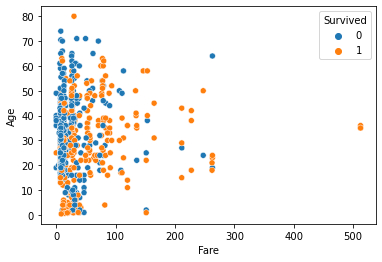

In [6]:
sns.scatterplot(x='Fare', y='Age', data=train_data, hue='Survived')

Midle Aged passengers were the most common.

Ages under adults have highest survival percentages

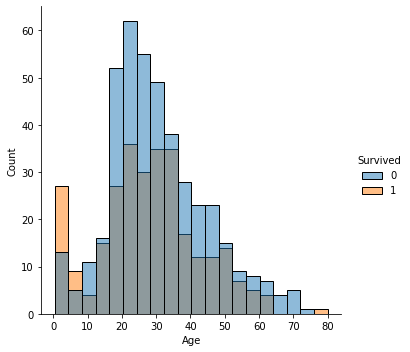

In [7]:
sns.displot(data=train_data, x='Age', hue='Survived')

<AxesSubplot:xlabel='Age_Category', ylabel='count'>

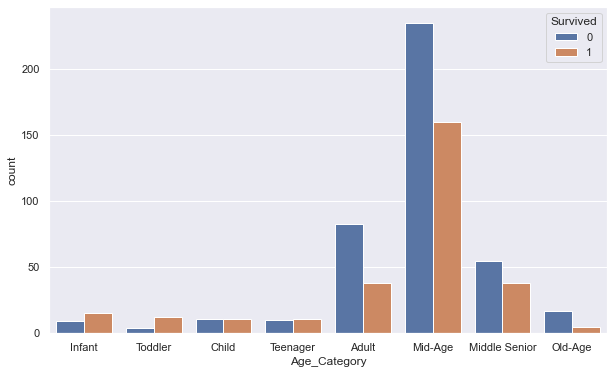

In [8]:
visualize_age = train_data[['Age', 'Survived', 'Ticket']].copy()
visualize_age['Age_Category'] = pd.cut(
    x=visualize_age.Age, 
    bins=[0, 2, 4, 9, 15, 21, 44, 60, 80], 
    labels=['Infant', 'Toddler', 'Child', 'Teenager', 'Adult', 'Mid-Age', 'Middle Senior', 'Old-Age'], 
    include_lowest=True)

sns.set(rc={'figure.figsize':(10, 6)})
sns.countplot(x='Age_Category', data=visualize_age, hue='Survived')

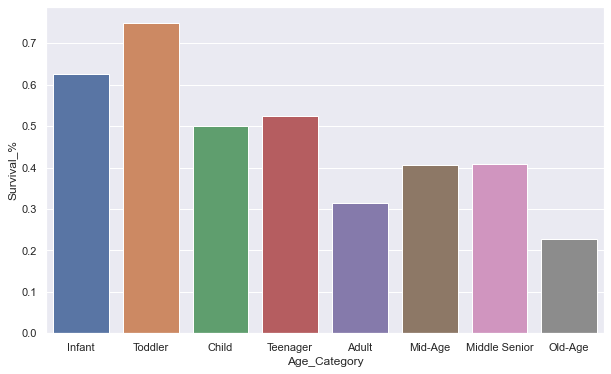

In [9]:
age_survival_perc = pd.pivot_table(columns=['Survived'], index='Age_Category', values='Ticket', aggfunc='count', data=visualize_age)
age_survival_perc = age_survival_perc.div(age_survival_perc.sum(axis=1), axis=0)
age_survival_perc.columns = ['Died', 'Survival_%']
sns.barplot(x='Age_Category', y='Survival_%', data=age_survival_perc.reset_index())
plt.show()

Passenger class 1 had the largest Survival percentage, and Passenger class 3 had the lowest. 

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

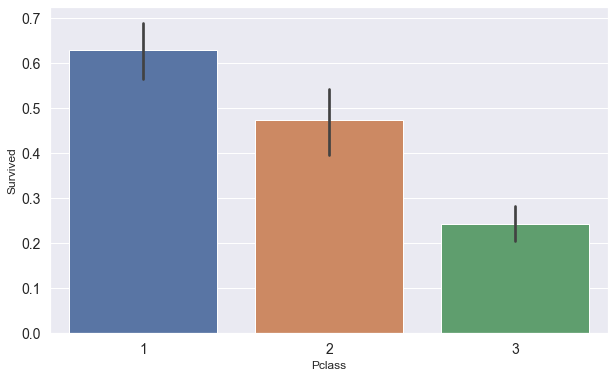

In [10]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

sns.barplot(x='Pclass', y='Survived', data=train_data)

<AxesSubplot:xlabel='Pclass', ylabel='Survival_%'>

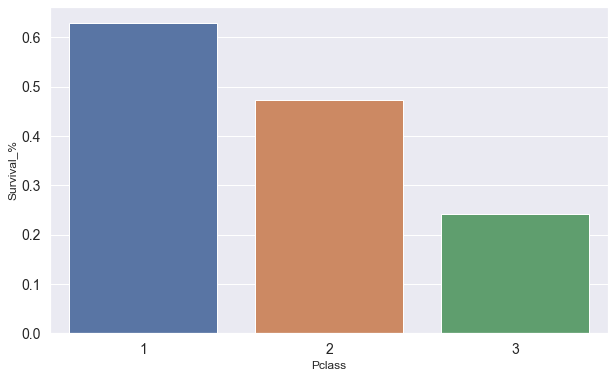

In [11]:
class_survival_perc = pd.pivot_table(columns=['Survived'], index='Pclass', values='Ticket', aggfunc='count', data=train_data)
class_survival_perc = class_survival_perc.div(class_survival_perc.sum(axis=1), axis=0)
class_survival_perc.columns = ['Died', 'Survival_%']
sns.barplot(x='Pclass', y='Survival_%', data=class_survival_perc.reset_index())

## Parch (N_Parents / N_Children) - SibSp(Siblings / Spouses)
Most survivors were travelling alone 

<AxesSubplot:xlabel='SibSp', ylabel='count'>

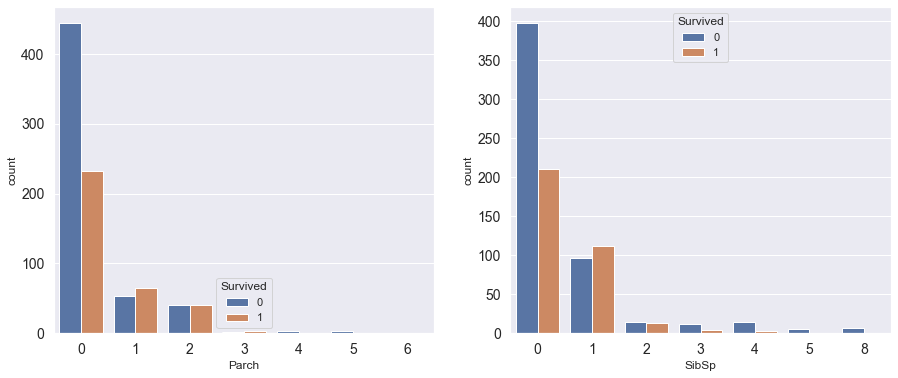

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.countplot(x='Parch', data=train_data, hue='Survived', ax=axs[0])
sns.countplot(x='SibSp', data=train_data, hue='Survived', ax=axs[1])

In [13]:
# Model Parameters
RANDOM_STATE = 2
MAX_DEPTH = 3
N_ESTIMATORS = 250

In [14]:
features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
y = train_data["Survived"]

# Split train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=RANDOM_STATE)

In [15]:
# Training
model = RandomForestClassifier(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH, random_state=RANDOM_STATE)
model.fit(X_train, y_train)


RandomForestClassifier(max_depth=3, n_estimators=250, random_state=2)

In [16]:
# Evaluation Metrics
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy} | F1 Score: {f1}")

Accuracy: 0.7873134328358209 | F1 Score: 0.6984126984126984


# Track with MLflow

In [17]:
EXPERIMENT_NAME = "titanic_exp"
EXPORT_MODEL_PATH = "titanic_model.pkl"


In [18]:
# Export model
with open(EXPORT_MODEL_PATH, 'wb') as handle:
    pickle.dump(model, handle)

In [19]:
repo = git.Repo(r"./")

def print_repository_info(repo):
    print('Repository description: {}'.format(repo.description))
    print('Repository active branch is {}'.format(repo.active_branch))

    for remote in repo.remotes:
        print('Remote named "{}" with URL "{}"'.format(remote, remote.url))

    print('Last commit for repository is {}.'.format(str(repo.head.commit.hexsha)))

    
def print_commit_data(commit, req_ver): 

    print('-----')
    print(str(commit.hexsha))
    print("\"{}\" by {} ({})".format(commit.summary, commit.author.name, commit.author.email))
    print(str(commit.authored_datetime))
    print(str("count: {} and size: {}".format(commit.count(), commit.size)))    
    if req_ver in commit.summary:
        return(str(commit.hexsha))
    else :
        return("")
    
    
    

# check that the repository loaded correctly
if not repo.bare:
    print('Repo at {} successfully loaded.')
    print_repository_info(repo)
    COMMITS_TO_PRINT = 10
    MAIN_BRANCH='main'
    
    # create list of commits then print some of them to stdout
    commits = list(repo.iter_commits(MAIN_BRANCH))[:COMMITS_TO_PRINT]
    print("----Commits---")
    print(commits)
    print("length of commits")
    print(len(commits))
    number = 0
    rev1 = ""
    req_ver = "v1"
    while ((number < len(commits)) and rev1 == ""):
        print(f"Number is {number}!")
        rev1 = print_commit_data(commits[number], req_ver)
        number = number + 1
        
    
    print("rev1")
    print(rev1)

    resource_url2 = dvc.api.get_url(
    'data/train.csv',
    repo = r"./",
    rev = rev1
    )
    print('-----')
    print(resource_url2)    
        
    df = pd.read_csv(resource_url2, sep=',')
    print(len(df))
    display(df)    

    
    
    remote_server_uri = "http://127.0.0.1:5000" # set to your server URI
    mlflow.set_tracking_uri(remote_server_uri)

    # Initialize client and experiment
    client = MlflowClient()
    mlflow.set_experiment(EXPERIMENT_NAME)
    exp = client.get_experiment_by_name(EXPERIMENT_NAME)

    # Start a new run and track 
    with mlflow.start_run(experiment_id=exp.experiment_id):
        mlflow.log_param("n_estimators", N_ESTIMATORS)      # Track model parameter
        mlflow.log_param("max_depth", MAX_DEPTH)            # Track model parameter
        mlflow.log_metric("accuracy", accuracy)             # Track error value
        mlflow.log_metric("f1_score", f1)                   # Track error value
        mlflow.log_artifact(EXPORT_MODEL_PATH)              # Track exported model
else:
    print('Could not load repository')

Repo at {} successfully loaded.
Repository description: Unnamed repository; edit this file 'description' to name the repository.
Repository active branch is main
Remote named "origin" with URL "https://github.com/Omar-Safwat/MLflow-and-dvc-example.git"
Last commit for repository is af3487267ca563d23b04892c101fabe0749b31c3.
----Commits---
[<git.Commit "af3487267ca563d23b04892c101fabe0749b31c3">, <git.Commit "faa533fe0d272351b7bc6215f20fe1475492ae6d">, <git.Commit "888acd19578438ef462870b55a1dc761a362d823">, <git.Commit "fcc24a35a2c20d9be764466dc7c0fd72fc3eafc2">, <git.Commit "4812fb2711e7b4af0d835ac104209dae5819053d">, <git.Commit "0746f704c0be021def744bda5a954d27b2428bd0">, <git.Commit "75c06f6b399ee60ff9c795e4f6e014e3a1194b1b">, <git.Commit "cc11c7aff37132b20ff6735f73391c21fc6fd512">, <git.Commit "dd5285400af017bc667cd910c8e629fc7f43ea5d">, <git.Commit "1aa4dcf8f0822c8c885caa77b3e97eee120c51c1">]
length of commits
10
Number is 0!
-----
af3487267ca563d23b04892c101fabe0749b31c3
"Finishi

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Retrieve Experiment

In [20]:
# Get experiment
exp = client.get_experiment_by_name(EXPERIMENT_NAME)

# Get all runs 
runs = mlflow.search_runs([exp.experiment_id])
runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.f1_score,metrics.accuracy,params.n_estimators,params.max_depth,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type
0,8723ccc1e8c44b7f8b606e6d3c1df78a,1,FINISHED,file:///D:/Me/Codes/Jupyter%20Notebooks/ITI%20...,2021-12-06 19:30:12.614000+00:00,2021-12-06 19:30:12.902000+00:00,0.698413,0.787313,250,3,C:\Users\moham\anaconda3\lib\site-packages\ipy...,moham,LOCAL
1,e30206759abb4bdbaa263ac921729f86,1,FINISHED,file:///D:/Me/Codes/Jupyter%20Notebooks/ITI%20...,2021-12-06 19:28:21.775000+00:00,2021-12-06 19:28:22.137000+00:00,0.698413,0.787313,250,3,C:\Users\moham\anaconda3\lib\site-packages\ipy...,moham,LOCAL
2,1cfcee6ea7d34276bced1ed632233e16,1,FINISHED,file:///D:/Me/Codes/Jupyter%20Notebooks/ITI%20...,2021-12-06 19:19:05.752000+00:00,2021-12-06 19:19:06.081000+00:00,0.698413,0.787313,250,3,C:\Users\moham\anaconda3\lib\site-packages\ipy...,moham,LOCAL
3,076ee98fbaee4cae8703133cd644c976,1,FINISHED,file:///D:/Me/Codes/Jupyter%20Notebooks/ITI%20...,2021-12-06 17:18:14.537000+00:00,2021-12-06 17:18:14.705000+00:00,0.698413,0.787313,250,3,C:\Users\moham\anaconda3\lib\site-packages\ipy...,moham,LOCAL
4,665d5e27db4a4e08a46b2dea1793dba6,1,FINISHED,file:///D:/Me/Codes/Jupyter%20Notebooks/ITI%20...,2021-12-06 17:17:47.911000+00:00,2021-12-06 17:17:48.192000+00:00,0.644068,0.764925,300,7,C:\Users\moham\anaconda3\lib\site-packages\ipy...,moham,LOCAL
5,2733b416712443768656cb7e19b74ec2,1,FINISHED,file:///D:/Me/Codes/Jupyter%20Notebooks/ITI%20...,2021-12-06 17:17:28.630000+00:00,2021-12-06 17:17:28.839000+00:00,0.644068,0.764925,100,7,C:\Users\moham\anaconda3\lib\site-packages\ipy...,moham,LOCAL
6,d0834eb216cb4fdab1eb84324700de47,1,FINISHED,file:///D:/Me/Codes/Jupyter%20Notebooks/ITI%20...,2021-12-06 17:16:28.711000+00:00,2021-12-06 17:16:28.847000+00:00,0.666667,0.772388,500,5,C:\Users\moham\anaconda3\lib\site-packages\ipy...,moham,LOCAL
7,cf178e56f3ef4ad08e653dbbdb8f503c,1,FINISHED,file:///D:/Me/Codes/Jupyter%20Notebooks/ITI%20...,2021-12-06 17:07:21.807000+00:00,2021-12-06 17:07:22.129000+00:00,0.698413,0.787313,100,3,C:\Users\moham\anaconda3\lib\site-packages\ipy...,moham,LOCAL
8,c3e5b58242eb4e73bcef6dbefd682a47,1,FAILED,file:///D:/Me/Codes/Jupyter%20Notebooks/ITI%20...,2021-12-06 17:05:36.557000+00:00,2021-12-06 17:05:36.779000+00:00,0.698413,0.787313,100,3,C:\Users\moham\anaconda3\lib\site-packages\ipy...,moham,LOCAL


# Retrieve Best Model

In [21]:
# Sort by error values and get the first entry
best_run = runs.sort_values(['metrics.f1_score']).iloc[0]
best_run

run_id                                      665d5e27db4a4e08a46b2dea1793dba6
experiment_id                                                              1
status                                                              FINISHED
artifact_uri               file:///D:/Me/Codes/Jupyter%20Notebooks/ITI%20...
start_time                                  2021-12-06 17:17:47.911000+00:00
end_time                                    2021-12-06 17:17:48.192000+00:00
metrics.f1_score                                                    0.644068
metrics.accuracy                                                    0.764925
params.n_estimators                                                      300
params.max_depth                                                           7
tags.mlflow.source.name    C:\Users\moham\anaconda3\lib\site-packages\ipy...
tags.mlflow.user                                                       moham
tags.mlflow.source.type                                                LOCAL